In [88]:
%matplotlib inline
import os
import copy
import random
import pandas as pd
import numpy as np
import torch
from torch import autograd
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [89]:
from os import listdir
from pathlib import Path
def load_dir(dir):
    images = []
    masks = []
    label = []
    resize = T.Resize((128,128))
   
    for file in listdir(f"{dir}/malignant"):
        if file.endswith(".png") and "mask" not in file:
            image = read_image(f"{dir}/malignant/{file}", ImageReadMode.GRAY)
            image = resize(image)
            image = TF.convert_image_dtype(image, dtype=torch.float32)
                
            filename = file.split(".")[0]
            files_list = list(Path(f"{dir}/malignant").rglob(f"{filename}*"))
            masks_list = [f for f in files_list if "mask" in str(f)]

            if len(masks_list) == 1:
                    mask_file = masks_list[0]
                    mask = read_image(f"{mask_file}", ImageReadMode.GRAY)
                    mask = resize(mask)
                    mask = TF.convert_image_dtype(mask, dtype=torch.float32)
                        
                    images.append(image)
                    masks.append(mask)
                    label.append("malignant")
                        
            else:
                continue
                    
    return images, masks, label

In [90]:
class BUSI_dataset(Dataset):
    def __init__(self, path):
        self.images, self.masks, labels = load_dir(path)
        self.transform = T.Compose([
            T.Normalize(0.5, 0.5),
        ])
        
        encLabel = LabelEncoder().fit_transform(labels)
        self.labels = torch.from_numpy(encLabel)
    
    def __getitem__(self, index):
        return self.transform(self.images[index]), self.transform(self.masks[index]), self.labels[index]
    
    def __len__(self):
        return len(self.images)

In [91]:
path = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dataset = BUSI_dataset(path)
dataLoader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [92]:
def show_image(images):
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()), nrow=8, normalize=True).permute(1, 2, 0))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor(0)


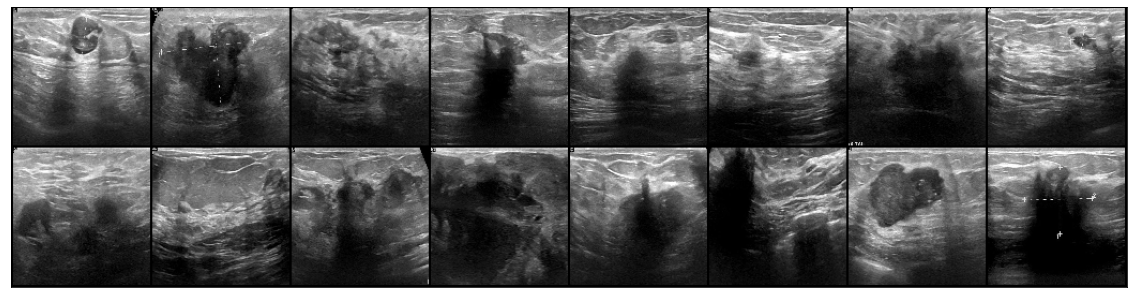

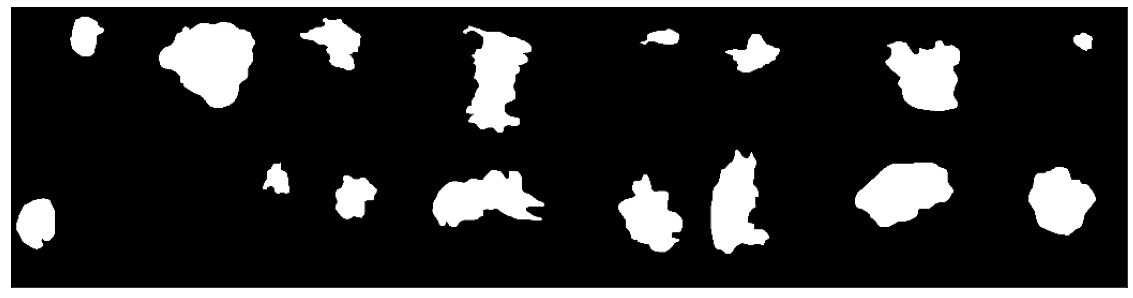

In [93]:
data = next(iter(dataLoader))
print(data[2], data[2][4])
show_image(data[0])
show_image(data[1])

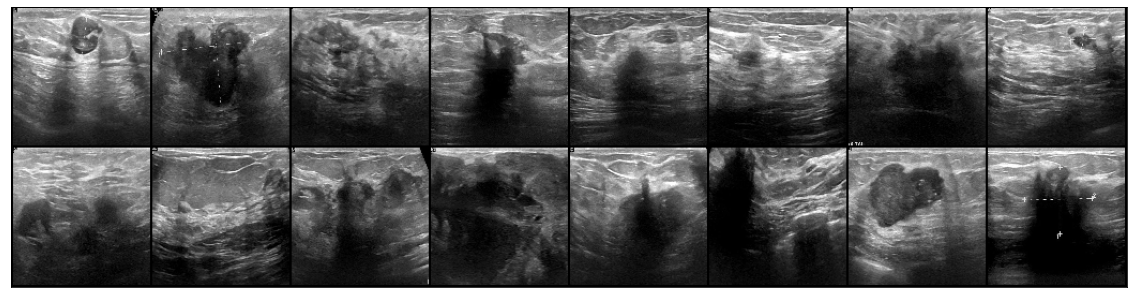

In [94]:
show_image(data[0])

In [95]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [96]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GenBlock, self).__init__()
        
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.relu(x)

class DisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_size, kernel_size, stride=1, padding=0):
        super(DisBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.LayerNorm([out_channels, img_size//2, img_size//2])
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.relu(x)

In [97]:
##Generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Generator, self).__init__()
        
        self.inBlock = GenBlock(in_channels, mid_channels, kernel_size=4, stride=1, padding=0)  #4x4
        self.net = nn.Sequential(
            GenBlock(mid_channels, mid_channels//2, kernel_size=4, stride=2, padding=1),  #8x8
            GenBlock(mid_channels//2, mid_channels//4, kernel_size=4, stride=2, padding=1),  #16x16
            GenBlock(mid_channels//4, mid_channels//8, kernel_size=4, stride=2, padding=1),  #32x32
            GenBlock(mid_channels//8, mid_channels//16, kernel_size=4, stride=2, padding=1),  #64x64
            nn.ConvTranspose2d(mid_channels//16, out_channels, kernel_size=4, stride=2, padding=1),#128x128
            nn.Tanh())
        
        self.embedding = nn.Embedding(3, 50)
        self.linear = nn.Linear(50, 4*4)
        
    def forward(self, x):
        #y = self.embedding(label)
        #y = self.linear(y).view(-1,1,4,4)
        x = self.inBlock(x)
        #x = torch.cat((x,y), dim=1)
        return self.net(x)

In [98]:
## Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super(Discriminator, self).__init__()
        
        self.embedding = nn.Embedding(3, 50)
        self.inLinear = nn.Linear(50, 128*128)
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            DisBlock(mid_channels, mid_channels*2, 64, 4, 2, 1),
            DisBlock(mid_channels*2, mid_channels*4, 32, 4, 2, 1),
            DisBlock(mid_channels*4, mid_channels*8, 16, 4, 2, 1),
            DisBlock(mid_channels*8, mid_channels*16, 8, 4, 2, 1),
            nn.Conv2d(mid_channels*16, 1, 4, 1, 0)
        )
    
    def forward(self, x):
        #y = self.embedding(label)
        #y = self.inLinear(y).view(-1,1,128,128)
        #x = torch.cat((x,y), dim=1)
        x = self.net(x)
        return x

In [99]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()
    
    def forward(self, inputs, targets):
        loss = torch.mean(inputs * targets)
        return loss

In [100]:
def generate_samples(GNet, device):
    B = 8
    nz = 100
    with torch.no_grad():
        noise = torch.randn(B,nz,1,1,device=device)
        noisyLabel = torch.randint(0, 3, (B,), device=device)
        output = GNet(noise).permute(1,0,2,3).to("cpu")
        images = torch.unsqueeze(output[0],dim=1)
        masks = torch.unsqueeze(output[1],dim=1)
        show_image(images)
        show_image(masks)

In [101]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), dtype=torch.float, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates).view(real_samples.size(0), -1)
    fake = torch.full((real_samples.shape[0], 1), 1.0, dtype=torch.float, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100
GNet = Generator(nz, 1024, 2).to(device)
GNet.apply(weights_init)
DNet = Discriminator(2, 32).to(device)
DNet.apply(weights_init)

optimizerG = optim.Adam(GNet.parameters(), lr=0.0001, betas=(0,0.9))
optimizerD = optim.Adam(DNet.parameters(), lr=0.0001, betas=(0,0.9))

criterion = WassersteinLoss()

real_label = -1
fake_label = 1

cr_iter_per_gen_iter = 5
#clip_limit = 0.5
lambda_gp = 10

disc_loss = []
gen_loss = []
num_epochs = 800

for e in range(num_epochs):
    dLossFake = 0
    dLossReal = 0
    dLoss = 0
    gLoss = 0
    
    for i, (image, mask, imgLabel) in enumerate(dataLoader, 1):
        image = torch.squeeze(image)
        mask = torch.squeeze(mask)
        imgLabel = imgLabel.to(device)
        
        try:
            B, H, W = image.shape
            real_input = torch.stack((image, mask)).permute(1,0,2,3).to(device)
            label = torch.full((B,), real_label, dtype=torch.float, device=device)
            DNet.zero_grad()
            
            sOutput = DNet(real_input).view(-1)
            dLoss_real = criterion(sOutput, label)

            dLoss_real.backward()

            noise = torch.randn(B, nz, 1, 1, device=device)
            noisyLabel = torch.randint(0, 3, (B,), device=device)
            fake_input = GNet(noise)
            label.fill_(fake_label)

            sOutput = DNet(fake_input.detach()).view(-1)
            dLoss_fake = criterion(sOutput, label)

            dLoss_fake.backward()

            gradient_penalty = lambda_gp * compute_gradient_penalty(DNet, real_input, fake_input.detach(), device)
            gradient_penalty.backward()

            optimizerD.step()
        
            """"for p in DNet.parameters():
                p.data.clamp_(-clip_limit, clip_limit)"""

            dLossReal += dLoss_real 
            dLossFake += dLoss_fake

            dLoss = dLossFake - dLossReal

            if i % cr_iter_per_gen_iter == 0:
                GNet.zero_grad()
                label.fill_(real_label)

                sOutput = DNet(fake_input).view(-1)
                gLoss_ = criterion(sOutput, label)
                gLoss_.backward()

                optimizerG.step()

                gLoss += gLoss_
        except:
            B=16
            H=128
            W=128
            
       
      
    
    #if (e+1)%50 == 0:
        #generate_samples(GNet, device)
        
    disc_loss.append(dLoss.item())
    gen_loss.append(gLoss.item())
    if (e+1)%10 == 0:
        print('Epoch {:.0f}/{:.0f} : Discriminator real loss: {:.4f} | Discriminator fake loss: {:.4f} | Discriminator loss: {:.4f} | Generator loss: {:.4f}'.format(e+1, num_epochs, dLossReal, dLossFake, dLoss, gLoss))

Epoch 10/800 : Discriminator real loss: -1320.3955 | Discriminator fake loss: -1299.4772 | Discriminator loss: 20.9183 | Generator loss: 188.7267
Epoch 20/800 : Discriminator real loss: -1466.1880 | Discriminator fake loss: -1295.9159 | Discriminator loss: 170.2721 | Generator loss: 198.3750
Epoch 30/800 : Discriminator real loss: -1578.1270 | Discriminator fake loss: -913.6371 | Discriminator loss: 664.4898 | Generator loss: 120.6485
Epoch 40/800 : Discriminator real loss: -1122.0034 | Discriminator fake loss: -827.8653 | Discriminator loss: 294.1381 | Generator loss: 163.7241
Epoch 50/800 : Discriminator real loss: -1004.5417 | Discriminator fake loss: -443.4747 | Discriminator loss: 561.0670 | Generator loss: 22.7325
Epoch 60/800 : Discriminator real loss: -701.3175 | Discriminator fake loss: -464.7759 | Discriminator loss: 236.5416 | Generator loss: 44.0453
Epoch 70/800 : Discriminator real loss: -350.4728 | Discriminator fake loss: -449.4421 | Discriminator loss: -98.9693 | Genera

Text(0, 0.5, 'Critic Score')

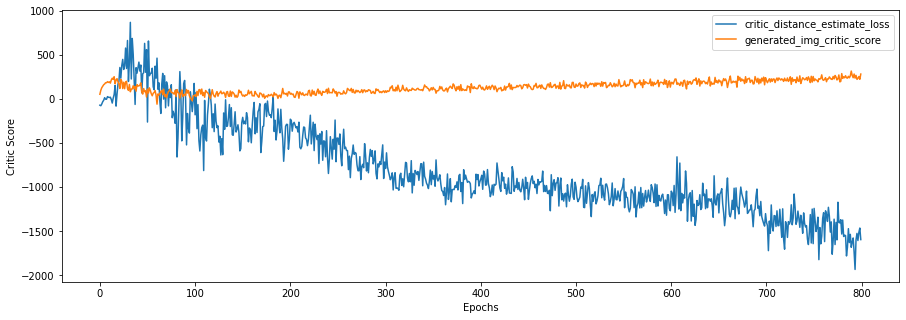

In [103]:
fig = plt.figure(figsize=[15,5])
plt.plot(range(num_epochs), disc_loss, label='critic_distance_estimate_loss')
plt.plot(range(num_epochs), gen_loss, label='generated_img_critic_score')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Critic Score')

In [113]:
def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()

In [105]:
# import os
# os.mkdir("./AugmentedImages")

In [118]:
os.mkdir("./AugmentedImages/malignant")

In [117]:
os.mkdir("./AugmentedImages")

In [115]:
from torchvision.utils import save_image
import torchvision.transforms as TR
from PIL import Image
originalSize=211
def generate_samples(GNet, device):
    path = "./AugmentedImages"
    B = 789 # no of generated images
    nz = 100
    with torch.no_grad():
        noise = torch.randn(B,nz,1,1,device=device) #Returns a tensor filled with random numbers from a normal distribution
        noisyLabel = torch.randint(0, 3, (B,), device=device)
        output = GNet(noise).permute(1,0,2,3).to("cpu")
        images = torch.unsqueeze(output[0],dim=1)
        masks = torch.unsqueeze(output[1],dim=1)
        
        #img=images[0]
        #msk=masks[0]
        #show_image(img)
        #show_image(msk)
        #print(noisyLabel)
        #imgLabel = imgLabel.to(device)
         #label=output[2]
       
        for i,(img,msk) in enumerate(zip(images,masks)):
             save_image(img, f"./AugmentedImages/malignant ("+str(i + originalSize +1) +").png")
        for i,(img,msk) in enumerate(zip(images,masks)):
             save_image(msk, f"./AugmentedImages/malignant ("+str(i + originalSize +1) +")_mask.png")
             
            
        




In [119]:
generate_samples(GNet, device)

In [ ]:
checkpoint = {
    'generator': Generator(nz, 1024, 2),
    'state_dict': GNet.state_dict()
}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
torch.save(GNet, 'model.pth')

In [116]:
# import shutil
# shutil.rmtree("./AugmentedImages")